# Score SNPs

Use trained models to score SNPs.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
from modisco.visualization import viz_sequence
import logomaker
from copy import deepcopy
from tqdm import tqdm

import sys
sys.path.append("/users/surag/kundajelab/retina-models/src/")
from utils.loss import multinomial_nll
from utils import one_hot
from utils.data_utils import load_test_data, get_seq
from utils.shap_utils import shuffle_several_times, combine_mult_and_diffref

import shap
import glob
tf.compat.v1.disable_eager_execution()

from metrics import softmax 
import scipy.stats
from mhc import multiple_testing_correction

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
def get_profile(output):
    prof, cts = output
    return softmax(prof)*(np.exp(cts)-1)

## Load Models

In [4]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [5]:
models = defaultdict(dict)
ctypes = []
FOLDS = 5

with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    for x in glob.glob("/srv/scratch/surag/tmp/retina/models/20220202_bpnet/fold0/*.h5"):
        ctype = x.split("/")[-1].split(".")[0]
        ctypes.append(ctype)
        print(ctype)
        
        for i in range(FOLDS):
            models[ctype][i] = tf.keras.models.load_model(x.replace("fold0", "fold" + str(i)))

Rod
OFFconebipolar
Retinalganglioncell
Horizontal
AIIamacrine
Microglia
Glyamacrine
Mullerglia
GABAamacrine
ONconebipolar
Astrocyte
Cone
Rodbipolar


In [6]:
len(ctypes)

13

In [7]:
model_count_explainers = defaultdict(dict)

# explainers
for x in ctypes:
    for i in range(FOLDS):
        model_count_explainers[x][i] = shap.explainers.deep.TFDeepExplainer(
                (models[x][i].input,
                 tf.reduce_sum(models[x][i].outputs[1], axis=-1)),
                shuffle_several_times,
                combine_mult_and_diffref=combine_mult_and_diffref)

In [8]:
INP_LEN = models[ctypes[0]][0].input_shape[1]
OUT_LEN = models[ctypes[0]][0].output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

In [9]:
snp_lists = dict()

for x in glob.glob("/srv/scratch/surag/tmp/retina/SNPs/SNPs_*"):
    set_name = x.split("_")[-1].split(".")[0]
    
    snp_lists[set_name] = pd.read_csv(x,
                       sep='\t',
                      names=['chr', 'start', 'rs', 'ref', 'alt'])

In [10]:
snp_lists.keys()

dict_keys(['randomInPeaks', 'Tier3Retina', 'allRetina', 'random', 'overlapPeaksRetina', 'Tier2Retina'])

In [11]:
# allRetina is a subset of all those with Retina, so collapse them
snp_lists['allRetina']['isTier2'] = snp_lists['allRetina']['rs'].isin(snp_lists['Tier2Retina']['rs'])
snp_lists['allRetina']['isTier3'] = snp_lists['allRetina']['rs'].isin(snp_lists['Tier3Retina']['rs'])
snp_lists['allRetina']['isInPeaks'] = snp_lists['allRetina']['rs'].isin(snp_lists['overlapPeaksRetina']['rs'])

del snp_lists['Tier2Retina']
del snp_lists['Tier3Retina']
del snp_lists['overlapPeaksRetina']

# randomInPeaks is a subset of all those in random, so collapse them
snp_lists['random']['isInPeaks'] = snp_lists['random']['rs'].isin(snp_lists['randomInPeaks']['rs'])

del snp_lists['randomInPeaks']

In [12]:
snp_lists.keys()

dict_keys(['allRetina', 'random'])

In [13]:
snp_lists['allRetina'].shape, snp_lists['random'].shape

((7034, 8), (10000, 6))

In [14]:
snp_lists['allRetina'].sample(10)

,chr,start,rs,ref,alt,isTier2,isTier3,isInPeaks
4519,chr11,89638383,rs10765220,A,G,False,False,False
6586,chr19,19519193,rs78883953,G,A,False,False,False
1035,chr2,177969325,rs55804196,G,T,False,False,False
2735,chr7,81230452,rs327742,G,A,False,False,False
6197,chr17,39444864,rs11659010,A,G,False,False,False
688,chr1,229105912,rs6701791,A,G,False,False,False
1168,chr3,15968297,rs4685286,C,G,False,False,False
3562,chr10,10802610,rs7913127,T,G,False,False,False
760,chr2,45397771,rs72616915,A,C,False,False,False
5279,chr13,85011101,rs9575712,G,A,False,False,False


In [15]:
snp_lists['random'].sum()['isInPeaks']

1368

In [16]:
for x in snp_lists:
    # remove non standard
    snp_lists[x] = snp_lists[x][snp_lists[x]['chr'].transform(lambda x: x in hg38.keys())==True]

    print(snp_lists[x].shape)
    
# moves from random, not allRetina

(7034, 8)
(9998, 6)


In [17]:
# jittered examples
# snp_list['start'] = snp_list['start'].transform(lambda x: x + np.random.choice([-15,15]))

In [18]:
snp_lists['random'].head()

,chr,start,rs,ref,alt,isInPeaks
0,chr1,626917,rs1189311909,T,C,False
1,chr1,1040936,rs1169505147,A,G,True
2,chr1,1045598,rs1015759906,C,T,True
3,chr1,1168811,rs1363396849,G,C,False
4,chr1,1208612,rs1003743472,C,T,True


In [19]:
BUFFER = 500 # to adjust for indels

ref_one_hots = defaultdict(list)
alt_one_hots = defaultdict(list)
ref_mismatch = 0

for x in snp_lists:
#     print(x)
    for _, y in snp_lists[x].iterrows():
        ref_one_hots[x].append(str(hg38[y['chr']][(y['start'] - INP_LEN//2):(y['start'] + INP_LEN//2 + BUFFER)]))
        
        # correct those that don't match ref as per dataframe
        if ref_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['ref'])] != y['ref']:
            ref_mismatch += 1
            ref_one_hots[x][-1] = ref_one_hots[x][-1][:INP_LEN//2 - 1] + y['ref'] + ref_one_hots[x][-1][INP_LEN//2 - 1 + len(y['ref']):]
            assert(ref_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['ref'])] == y['ref'])
#             print(ref_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['ref'])], y['ref'], y['alt'])
        
        cur_alt = ref_one_hots[x][-1]
        cur_alt = cur_alt[:INP_LEN//2 - 1] + y['alt'] + cur_alt[INP_LEN//2 -1 + len(y['ref']):]
        alt_one_hots[x].append(cur_alt)
        assert(alt_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['alt'])] == y['alt'])
        
        # trim to model input length
        ref_one_hots[x][-1] = ref_one_hots[x][-1][:INP_LEN]
        alt_one_hots[x][-1] = alt_one_hots[x][-1][:INP_LEN]

    ref_one_hots[x] = one_hot.dna_to_one_hot(ref_one_hots[x])
    alt_one_hots[x] = one_hot.dna_to_one_hot(alt_one_hots[x])

In [20]:
# should be small compared to all SNPs
ref_mismatch

23

In [21]:
ref_one_hots['random'].shape, alt_one_hots['random'].shape, ref_one_hots['allRetina'].shape, alt_one_hots['allRetina'].shape

((9998, 2114, 4), (9998, 2114, 4), (7034, 2114, 4), (7034, 2114, 4))

## Score

In [ ]:
ref_preds = defaultdict(lambda: defaultdict(dict))
alt_preds = defaultdict(lambda: defaultdict(dict))

for sl in snp_lists:
    print(sl)
    for m in tqdm(models):
        for i in range(FOLDS):
            ref_preds[sl][m][i] = models[m][i].predict(ref_one_hots[sl], verbose=True, batch_size=256)
            alt_preds[sl][m][i] = models[m][i].predict(alt_one_hots[sl], verbose=True, batch_size=256)
    print('------')

  0%|          | 0/13 [00:00<?, ?it/s]

allRetina


/users/surag/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
  0%|          | 0/13 [00:00<?, ?it/s]

------
random


  8%|▊         | 1/13 [04:57<59:26, 297.20s/it]

## Aggregate across folds

In [26]:
def poisson_pval(ref, alt):
    # one sided (either test breaking peak or making peak), ref alt are log
    if ref <= 0:
        return 1
    
    if alt>ref:
        return 1-scipy.stats.poisson(np.exp(ref)-1).cdf(np.exp(alt)-1)
    else:
        return scipy.stats.poisson(np.exp(ref)-1).cdf(max(0,np.exp(alt)-1))

In [59]:
snp_score_dfs = dict()

for sl in snp_lists:
    cur_dict = OrderedDict()
    cur_dict['chr'] = snp_lists[sl]['chr']
    cur_dict['start'] = snp_lists[sl]['start']
    cur_dict['rs'] = snp_lists[sl]['rs']
    cur_dict['ref'] = snp_lists[sl]['ref']
    cur_dict['alt'] = snp_lists[sl]['alt']
    
    for m in models:
        print(m)
        all_folds = []
        refs = []
        alts = []
        
        for i in range(FOLDS):
            cur_lfc = (alt_preds[sl][m][i][1] - ref_preds[sl][m][i][1]).ravel() # simple counts lfc
            refs.append(ref_preds[sl][m][i][1].ravel())
            alts.append(alt_preds[sl][m][i][1].ravel())
        
            # JSD (fails for indels)
#             cur_lfc = [scipy.spatial.distance.jensenshannon(x,y) for x,y in zip(softmax(alt_preds[sl][m][i][0]), softmax(ref_preds[sl][m][i][0]))] # JSD 

            # counts LFC in central 100 bp
#             cur_lfc = np.log(1+get_profile(alt_preds[sl][m][i])[:, (OUT_LEN-100)//2:(OUT_LEN+100)//2].sum(-1)) - \
#                       np.log(1+get_profile(ref_preds[sl][m][i])[:, (OUT_LEN-100)//2:(OUT_LEN+100)//2].sum(-1))
        
            all_folds.append(list(cur_lfc))
        
        all_folds = np.array(all_folds).T
        mean_refs = np.array(refs).mean(0)
        mean_alts = np.array(alts).mean(0)
        
        cur_dict['{}_fold_avg_lfc'.format(m)] = all_folds.mean(-1)
        cur_dict['{}_avg_ref'.format(m)] = mean_refs
        cur_dict['{}_avg_alt'.format(m)] = mean_alts
        
        for i in range(FOLDS):
            cur_dict['{}_fold{}_lfc'.format(m,i)] = all_folds[:,i].copy()
        
        pvals = [poisson_pval(x,y) for x,y in zip(mean_refs, mean_alts)]
        cur_dict['{}_pval'.format(m)] = pvals
        
    snp_score_dfs[sl] = pd.DataFrame(cur_dict)

Rod
OFFconebipolar
Retinalganglioncell
Horizontal
AIIamacrine
Microglia
Glyamacrine
Mullerglia
GABAamacrine
ONconebipolar
Astrocyte
Cone
Rodbipolar
Rod
OFFconebipolar
Retinalganglioncell
Horizontal
AIIamacrine
Microglia
Glyamacrine
Mullerglia
GABAamacrine
ONconebipolar
Astrocyte
Cone
Rodbipolar


In [60]:
for sl in snp_lists:
    snp_score_dfs[sl]['fisher_fused_pval'] = snp_score_dfs[sl][['{}_pval'.format(m) for m in models]].\
                                                apply(lambda x: scipy.stats.combine_pvalues(x)[1], axis=1)
    snp_score_dfs[sl]['fdr'] = multiple_testing_correction(list(snp_score_dfs[sl]['fisher_fused_pval']))

/users/surag/anaconda3/envs/tf2/lib/python3.7/site-packages/scipy/stats/stats.py:6895: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))


In [61]:
for sl in snp_lists:
    snp_score_dfs[sl]['max_lfc'] = np.array(snp_score_dfs[sl][["{}_fold_avg_lfc".format(m) for m in models]].apply(lambda x: max(x, key=lambda y:abs(y)), 1))
    snp_score_dfs[sl]['max_log2fc'] = np.log2(np.exp(snp_score_dfs[sl]['max_lfc']))

In [62]:
LFC_CUTOFF = np.log(2**0.5)
FDR_CUTOFF = 0.01

for sl in snp_lists:
    snp_score_dfs[sl]['high_effect'] = np.int8((np.abs(snp_score_dfs[sl]['max_lfc']) > LFC_CUTOFF) & (snp_score_dfs[sl]['fdr'] < FDR_CUTOFF))

In [63]:
reordered_cols = list(snp_score_dfs['random'].columns)
reordered_cols = reordered_cols[:5] + reordered_cols[-5:] + reordered_cols[5:-5]

In [64]:
reordered_cols[:10]

['chr',
 'start',
 'rs',
 'ref',
 'alt',
 'fisher_fused_pval',
 'fdr',
 'max_lfc',
 'max_log2fc',
 'high_effect']

In [65]:
for sl in snp_lists:
    snp_score_dfs[sl] = snp_score_dfs[sl][reordered_cols]

In [67]:
# write out
# snp_score_dfs['allRetina'].to_csv("./snp_scores/allRetina.scored.tsv", sep='\t', index=False)
# snp_score_dfs['random'].to_csv("./snp_scores/random.scored.tsv", sep='\t', index=False)

## Collapse across cell types 

In [36]:
TOPK = 100

In [68]:
top_hits = defaultdict(list)

for sl in snp_lists:
    for m in models:
        cur_lfc = list(snp_score_dfs[sl]["{}_fold_avg_lfc".format(m)])
        cur_fdr = list(snp_score_dfs[sl]["fdr"])
        cur_hits = sorted(range(len(cur_lfc)), key=lambda x: -abs(cur_lfc[x]))
        cur_hits = [i for i in cur_hits if abs(cur_lfc[i]) >= LFC_CUTOFF]
        cur_hits = [i for i in cur_hits if abs(cur_fdr[i]) <= FDR_CUTOFF][:TOPK]        
        cur_hits = [(i, cur_lfc[i], cur_fdr[i], m) for i in cur_hits]

        top_hits[sl] += cur_hits

    top_hits[sl] = sorted(top_hits[sl], key=lambda x: -abs(x[1]))

In [69]:
len(top_hits['allRetina'])

111

In [54]:
len(top_hits["random"])/snp_lists['random'].shape[0], len(top_hits["allRetina"])/snp_lists['allRetina'].shape[0]

(0.008001600320064013, 0.011799829400056867)

In [652]:
# len(top_hits["random"])/snp_lists['random'].shape[0], len(top_hits["allRetina"])/snp_lists['allRetina'].shape[0]

In [49]:
retina_high_effect = snp_score_dfs['allRetina']['high_effect']
in_peaks = snp_lists['allRetina']['isInPeaks']
is_tier3 = snp_lists['allRetina']['isTier3']
is_tier2 = snp_lists['allRetina']['isTier2']

100*np.mean( retina_high_effect ),  \
100*np.mean( (retina_high_effect[in_peaks])),\
100*np.mean( (retina_high_effect[is_tier3]) ),\
100*np.mean( (retina_high_effect[is_tier2]) )

(0.5686664771111744,
 1.9965277777777777,
 2.1791767554479415,
 2.9268292682926833)

In [50]:
random_high_effect = snp_score_dfs['random']['high_effect']
random_in_peaks = snp_lists['random']['isInPeaks']

100*np.mean( random_high_effect ),  \
100*np.mean( random_high_effect[random_in_peaks] )

(0.550110022004401, 1.1695906432748537)

In [51]:
100*np.mean(snp_score_dfs['allRetina']['max_lfc']>LFC_CUTOFF), \
100*np.mean(snp_score_dfs['allRetina']['max_lfc'][in_peaks]>LFC_CUTOFF),\
100*np.mean(snp_score_dfs['allRetina']['max_lfc'][is_tier3]>LFC_CUTOFF),\
100*np.mean(snp_score_dfs['allRetina']['max_lfc'][is_tier2]>LFC_CUTOFF)

(0.398066533977822, 0.9548611111111112, 0.9685230024213075, 0.975609756097561)

In [52]:
import sklearn

In [53]:
x_pos = np.abs(snp_score_dfs['allRetina']['max_lfc'][snp_lists['allRetina']['isInPeaks']])
x_neg = np.abs(snp_score_dfs['random']['max_lfc'][snp_lists['random']['isInPeaks']])

In [45]:
scipy.stats.mannwhitneyu(x_pos, x_neg)

MannwhitneyuResult(statistic=727595.0, pvalue=0.00045335106025135084)

In [289]:
# enrichment
T=50
sum([x[0] for x in sorted(zip([1]*len(x_pos) + [0]*len(x_neg), np.concatenate([x_pos, x_neg])), key=lambda x: -x[1])][:T]) \
/(T*len(x_pos)/(len(x_pos) + len(x_neg)))

1.4

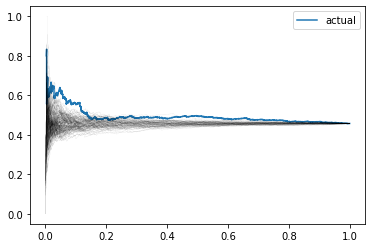

In [290]:
plt.plot(sklearn.metrics.precision_recall_curve([1]*len(x_pos) + [0]*len(x_neg),
                                       np.concatenate([x_pos, x_neg]))[1][:-5],
         sklearn.metrics.precision_recall_curve([1]*len(x_pos) + [0]*len(x_neg),
                                       np.concatenate([x_pos, x_neg]))[0][:-5],
        label='actual')



shuf_pred = np.concatenate([x_pos, x_neg])

for i in range(100):
    np.random.shuffle(shuf_pred) #in-place
    shuf_pr = sklearn.metrics.precision_recall_curve([1]*len(x_pos) + [0]*len(x_neg),
                                           shuf_pred)

    plt.plot(shuf_pr[1][:-5], shuf_pr[0][:-5], c='k', linewidth=.03, alpha=.8)
plt.legend()
# plt.ylim(.4,1.05)

In [291]:
scores = []
for i in range(10000):
    np.random.shuffle(shuf_pred) #in-place
    scores.append(sklearn.metrics.average_precision_score([1]*len(x_pos) + [0]*len(x_neg),
                                           shuf_pred))

In [292]:
sklearn.metrics.average_precision_score([1]*len(x_pos) + [0]*len(x_neg),
                                           np.concatenate([x_pos, x_neg]))

0.4951001098841339

In [293]:
sorted(scores)[::-1][:10]

[0.5110063127369955,
 0.4981855687300212,
 0.4948270774722829,
 0.49422582261873893,
 0.4932637755002775,
 0.49207181244663367,
 0.4912368623005695,
 0.49118198665798507,
 0.49072470028538345,
 0.4892976635417484]

In [308]:
top_hits['allRetina'][0]

(750, -1.3072130680084229, 0.0, 'Mullerglia')

In [556]:
list(top_df[top_df['rs']=='rs1874459']['other'])

[['Rodbipolar',
  'Glyamacrine',
  'ONconebipolar',
  'OFFconebipolar',
  'AIIamacrine']]

In [70]:
top_df = pd.DataFrame([(x[0], 
          snp_lists['allRetina'].iloc[x[0]]['rs'], 
          round(np.mean([ref_preds['allRetina'][x[3]][f][1][x[0]][0] for f in range(FOLDS)]),2), 
          round(x[1],2),
          round(np.sign(x[1])*np.exp(np.abs(x[1])), 2), 
          x[3],
          snp_lists['allRetina'].iloc[x[0]]['ref'],
          snp_lists['allRetina'].iloc[x[0]]['alt'],
          x[2],
          snp_lists['allRetina'].iloc[x[0]]['isInPeaks'], 
          snp_lists['allRetina'].iloc[x[0]]['isTier3'], 
          snp_lists['allRetina'].iloc[x[0]]['isTier2']) \
                       for x in top_hits['allRetina']],
            columns=["IDX", 'rs', 'ref_cts', 'LFC', 'FC', "celltype", 'ref', 'alt', 'fdr', 'isInPeaks', 'isTier3', 'isTier2'])

top_df['num_occ'] = top_df['IDX'].transform(lambda x: Counter(top_df['IDX'])[x])
top_df['other'] = top_df['IDX'].transform(lambda x: list(top_df[top_df['IDX']==x]['celltype']))
top_df = top_df.drop_duplicates(subset=['IDX']) # keep first insteance of SNP

print(top_df.shape)
top_df
# top_df[top_df['isInPeaks']]
# top_df[top_df['isTier2']]

(40, 14)


,IDX,rs,ref_cts,LFC,FC,celltype,ref,alt,fdr,isInPeaks,isTier3,isTier2,num_occ,other
0,750,rs75120545,6.55,-1.31,-3.70,Mullerglia,C,T,0.000000e+00,True,False,False,13,"[Mullerglia, OFFconebipolar, GABAamacrine, ONc..."
8,48,rs12734651,5.27,0.84,2.31,Rodbipolar,C,A,0.000000e+00,True,False,False,8,"[Rodbipolar, OFFconebipolar, ONconebipolar, Mi..."
12,3898,rs1649039,3.88,0.81,2.25,Rodbipolar,G,A,9.523869e-16,False,False,False,2,"[Rodbipolar, ONconebipolar]"
14,5854,rs257335,3.78,-0.80,-2.22,OFFconebipolar,G,A,1.331745e-05,False,False,False,5,"[OFFconebipolar, ONconebipolar, Rodbipolar, AI..."
16,3607,rs1153785,7.21,-0.75,-2.12,Rod,C,T,1.412841e-109,False,False,False,6,"[Rod, Microglia, ONconebipolar, Cone, Mullergl..."
17,3299,rs746970,5.39,-0.75,-2.11,Rodbipolar,A,G,1.865761e-14,True,False,False,2,"[Rodbipolar, ONconebipolar]"
18,5866,rs1874459,5.16,0.72,2.06,Rodbipolar,G,C,0.000000e+00,True,True,True,5,"[Rodbipolar, Glyamacrine, ONconebipolar, OFFco..."
22,6866,rs3788317,5.26,0.69,1.99,Rodbipolar,G,T,0.000000e+00,False,False,False,4,"[Rodbipolar, ONconebipolar, OFFconebipolar, Rod]"
23,3361,rs4977756,6.62,0.68,1.98,Rod,G,A,0.000000e+00,False,False,False,4,"[Rod, Cone, Mullerglia, ONconebipolar]"
24,3053,rs1532278,7.61,-0.68,-1.98,Mullerglia,T,C,1.521577e-118,True,True,True,1,[Mullerglia]


In [370]:
cur = snp_score_dfs['allRetina'].loc[snp_score_dfs['allRetina']['rs']=='rs1360935'].iloc[0]
for x in cur.keys():
    print(x, cur[x])

chr chr13
start 54569291
rs rs1360935
ref T
alt G
Rod_fold_avg_lfc -0.44441336
Rod_fold_avg_ref 6.4345026
Rod_fold_avg_alt 5.9900885
Rod_fold0_lfc -0.38262796
Rod_fold1_lfc -0.22281218
Rod_fold2_lfc -0.50627375
Rod_fold3_lfc -0.6776943
Rod_fold4_lfc -0.43265867
Rod_pval 4.35036114430757e-22
OFFconebipolar_fold_avg_lfc -0.56864935
OFFconebipolar_fold_avg_ref 4.803421
OFFconebipolar_fold_avg_alt 4.2347717
OFFconebipolar_fold0_lfc -0.7937753
OFFconebipolar_fold1_lfc -0.5029855
OFFconebipolar_fold2_lfc -0.64014006
OFFconebipolar_fold3_lfc -0.62289953
OFFconebipolar_fold4_lfc -0.2834463
OFFconebipolar_pval 1.1179567039238055e-07
Retinalganglioncell_fold_avg_lfc -0.009187555
Retinalganglioncell_fold_avg_ref 2.8609335
Retinalganglioncell_fold_avg_alt 2.851746
Retinalganglioncell_fold0_lfc 0.00611639
Retinalganglioncell_fold1_lfc -0.022814274
Retinalganglioncell_fold2_lfc 0.013639927
Retinalganglioncell_fold3_lfc -0.02725029
Retinalganglioncell_fold4_lfc -0.01562953
Retinalganglioncell_pval 1.

In [67]:
snp_score_dfs['allRetina'][snp_score_dfs['allRetina']['rs'] == "rs1874459"][["Rodbipolar_fold{}".format(i) for i in range(FOLDS)]]

,Rodbipolar_fold0,Rodbipolar_fold1,Rodbipolar_fold2,Rodbipolar_fold3,Rodbipolar_fold4
5866,0.406858,0.569088,0.827513,0.742638,1.065751


In [365]:
snp_score_dfs['allRetina'][snp_score_dfs['allRetina']['rs'] == "rs1532278"][["Mullerglia_fold{}".format(i) for i in range(FOLDS)]]

,Mullerglia_fold0,Mullerglia_fold1,Mullerglia_fold2,Mullerglia_fold3,Mullerglia_fold4
3053,-0.583887,-0.978409,-0.543894,-0.572269,-0.729104


In [692]:
# SNP LFC across cell states
CUR_IDX = 3053

pd.DataFrame(sorted([(m,
                      round(snp_score_dfs['allRetina']["{}_fold_avg".format(m)].iloc[CUR_IDX],2),
                      round(np.sign(snp_score_dfs['allRetina']["{}_fold_avg".format(m)].iloc[CUR_IDX]) * \
                            np.exp(np.abs(snp_score_dfs['allRetina']["{}_fold_avg".format(m)].iloc[CUR_IDX])),2),
                     round(ref_preds['allRetina'][m][0][1][CUR_IDX, 0],2)) \
                     for m in ctypes], 
                 key=lambda x:-abs(x[1])),
            columns=['celltype', 'LFC', 'FC', 'ref_cts'])

,celltype,LFC,FC,ref_cts
0,Mullerglia,-0.68,-1.98,7.49
1,Astrocyte,-0.16,-1.18,4.39
2,Retinalganglioncell,0.09,1.09,4.77
3,Microglia,-0.08,-1.09,4.03
4,AIIamacrine,-0.07,-1.08,4.47
5,OFFconebipolar,-0.06,-1.06,6.39
6,Rod,0.05,1.05,7.39
7,Horizontal,-0.04,-1.04,5.41
8,Glyamacrine,-0.04,-1.04,4.90
9,Cone,0.04,1.04,5.00


In [664]:
EXAMPLE_IDX = 750
CTYPE = 'Mullerglia'

cur_raw_seqs = np.vstack([ref_one_hots['allRetina'][EXAMPLE_IDX:EXAMPLE_IDX+1], 
                          alt_one_hots['allRetina'][EXAMPLE_IDX:EXAMPLE_IDX+1]])

counts_shap_scores = np.array([model_count_explainers[CTYPE][i].shap_values(cur_raw_seqs) for i in range(FOLDS)]).mean(0)
projected_shap_scores = np.multiply(cur_raw_seqs, counts_shap_scores)

In [665]:
snp_lists['allRetina'].iloc[EXAMPLE_IDX]

chr                chr2
start          44044357
rs           rs75120545
ref                   C
alt                   T
isTier2           False
isTier3           False
isInPeaks          True
Name: 750, dtype: object

In [666]:
one_hot.one_hot_to_dna(cur_raw_seqs)[0][1046:1076], one_hot.one_hot_to_dna(cur_raw_seqs)[1][1046:1076]

('CAGACTGGGACGCTAGATGGCAGGCTCACC', 'CAGACTGGGATGCTAGATGGCAGGCTCACC')

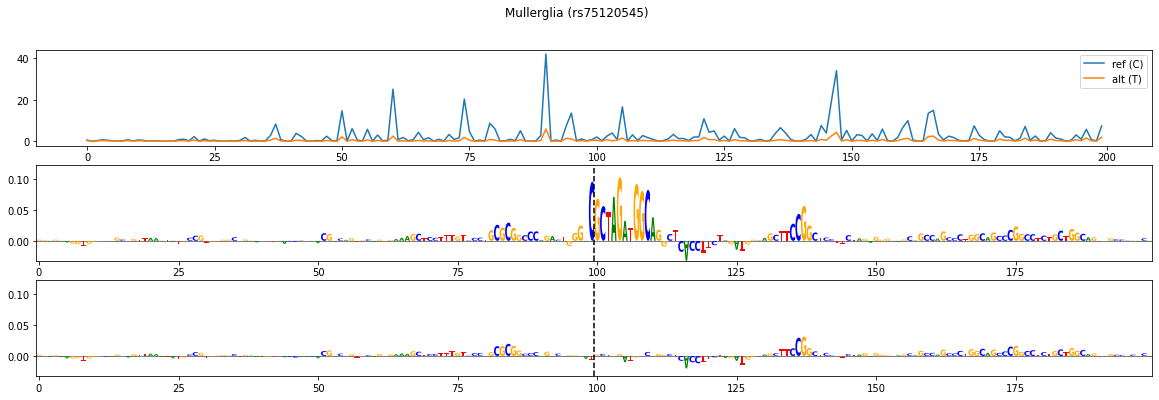

In [667]:
WINDOW = 200
SLICE_START = INP_LEN//2 - WINDOW//2
SLICE_END = INP_LEN//2 + WINDOW//2

ymin = np.min(projected_shap_scores)
ymax = np.max(projected_shap_scores) + 0.02

fig, ax = plt.subplots(3, figsize=(20,6))

ref_avg_prof = np.array([get_profile(ref_preds['allRetina'][CTYPE][i])[EXAMPLE_IDX] for i in range(FOLDS)]).mean(0)
alt_avg_prof = np.array([get_profile(alt_preds['allRetina'][CTYPE][i])[EXAMPLE_IDX] for i in range(FOLDS)]).mean(0)

ax[0].plot(ref_avg_prof[max(0,(OUT_LEN-WINDOW))//2:(OUT_LEN+WINDOW)//2], 
           label='ref ({})'.format(snp_lists['allRetina'].iloc[EXAMPLE_IDX]['ref']))
ax[0].plot(alt_avg_prof[max(0, (OUT_LEN-WINDOW)//2):(OUT_LEN+WINDOW)//2], 
           label='alt ({})'.format(snp_lists['allRetina'].iloc[EXAMPLE_IDX]['alt']))
ax[0].legend()

ax[1].vlines(1056 - SLICE_START + 0.5, ymin, ymax+1, 'k', linestyle='dashed')
ax[2].vlines(1056 - SLICE_START + 0.5, ymin, ymax+1, 'k', linestyle='dashed')

logomaker.Logo(pd.DataFrame(projected_shap_scores[0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
              ax=ax[1])
logomaker.Logo(pd.DataFrame(projected_shap_scores[1][SLICE_START:SLICE_END], columns=['A','C','G','T']),
              ax=ax[2])


ax[1].set_ylim(ymin, ymax)
ax[2].set_ylim(ymin, ymax)

fig.suptitle("{} ({})".format(CTYPE, snp_lists['allRetina'].iloc[EXAMPLE_IDX]['rs']))
plt.show()